# web框架

web框架是一种开发框架，用来支持动态网站、网络应用和网络服务的开发。这大多数的web框架提供了一套开发和部署网站的方式，也为web行为提供了一套通用的方法。web框架已经实现了很多功能，开发人员使用框架提供的方法并且完成自己的业务逻辑，就能快速开发web应用了。浏览器和服务器的是基于HTTP协议进行通信的。也可以说web框架就是在以上十几行代码基础张扩展出来的，有很多简单方便使用的方法，大大提高了开发的效率。

说的通俗一点，web框架就是别人写好的程序，用户只需要按照一定的规则，在该写的地方写该写的代码就能实现一个web服务器端。因为web服务器端要做的事情其实还是挺多的，比如socket的连接释放，请求的解析和响应的封装等。用户站在使用者的角度只需要舒舒服服地写业务代码即可。

我觉得只要一名开发人员开发年限在一年多以上，就应该去站在上帝视角去看待技术，对于web框架来说就是我们应该站在源码角度去看web框架的使用。

# wsgi规范

在web领域，可以把造轮子的先简单划分成2种人，一种是处理socket连接的server，一个是编写应用框架的app，要想2者可以无缝衔接，出现了一个叫wsgi规范的东西。wsgi对app有约束，对server也有约束，wsgi要求app必须是一个可接受两个参数的可调用对象(可以是一个对象，也可以是一个函数)。

In [1]:
def application(environ, start_response):
    status = "200 OK"
    response_headers = [("Content-Type", "text/plain")]
    start_response(status, response_headers)
    return [b"hello world"]

app需要接收2个参数
* environ： 请求信息字典
* start_response：一个可调用对象，用于设置响应状态码和响应头

wsgi server 的实现要复杂一些, 但无论多复杂, 要做的工作无外乎就是维护socket连接, 组成包含请求信息的environ, 并把这个服务端对响应头和响应状态码的处理函数交给app，app经过一堆复杂的处理给出结果，server端负责把结果发出去。具体server的实现可以参考tornado部分的。

wsgiref模块实现了兼容wsgi规范的server，可以简单看一下：

In [ ]:
from wsgiref.simple_server import make_server


def application(environ, start_response):
    status = "200 OK"
    response_headers = [("Content-Type", "text/plain")]
    start_response(status, response_headers)
    return [b"hello world"]

"""
def make_server(
    host, port, app, server_class=WSGIServer, handler_class=WSGIRequestHandler
):
    server = server_class((host, port), handler_class)
    server.set_app(app)
    return server
"""
server = make_server("", 9001, application)
server.serve_forever()

# 自定义简单的框架

利用wsgiref帮忙自定义一个web框架，技术上没啥难点，唯一需要注意的是**代码分层**，把内容包装成函数，把实现同样功能的放在一个py文件，把实现一个大功能的很多py文件放在一个包里。
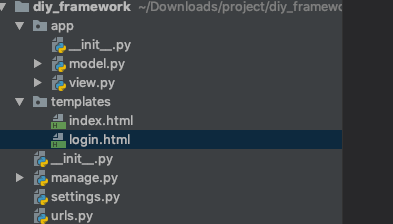

In [ ]:
# views.py
import urllib.parse
from app.model import UserRepository


def login(request):
    if request.get("REQUEST_METHOD") == "GET":
        with open("templates/login.html") as f:
            return f.read().encode("utf8")
    elif request.get("REQUEST_METHOD") == "POST":
        content_length = int(request.get('CONTENT_LENGTH', 0))
        request_body = request.get('wsgi.input').read(content_length)
        arguments = urllib.parse.parse_qs(request_body.decode("utf8"))
        UserRepository().create(arguments.get("user")
                                [0], arguments.get("pwd")[0],)
        return b"create success"


def index(request):
    with open("templates/index.html") as f:
        return f.read().encode("utf8")

In [ ]:
# model.py
import pymysql

from settings import mysql_conn_info


class UserRepository(object):
    """
    完成对user表的增删改查
    """

    def __init__(self):
        self.conn = pymysql.connect(**mysql_conn_info)
        self.cursor = self.conn.cursor()

    def create(self, user, pwd):
        # 增加记录
        sql = "insert into userinfo(name, pwd) values (%s, %s)"
        self.cursor.execute(sql, [user, pwd])
        self.close()

    def delete(self, user):
        # 删除记录
        pass

    def update(self, user):
        # 更新记录
        pass

    def select(self, user):
        # 查询记录
        pass

    def close(self):
        # 收尾工作
        self.conn.commit()
        self.cursor.close()
        self.conn.close()


In [ ]:
# manage.py
from wsgiref.simple_server import make_server
from urls import urls

def application(environ, start_response):
    path = environ.get("PATH_INFO")

    func = None
    for pattern in urls:
        if pattern[0] == path:
            func = pattern[1]
            break
    if not func:
        return [b"404"]
    response = func(environ)

    status = "200 OK"
    response_headers = [("Content-Type", "text/html")]
    start_response(status, response_headers)
    return [response]


server = make_server("", 9002, application)
server.serve_forever()

In [4]:
# settings.py
mysql_conn_info = {
    "host": '127.0.0.1',
    "port": 3306,
    "user": 'root',
    "passwd": '',
    "db": 'test',
    "charset": 'utf8'
}


In [ ]:
# urls.py
from app.view import login, index

urls = [
    (r"/login", login),
    (r"/index", index),
]

login.html
```html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>login</title>
</head>
<body>

<h4>创建用户页面</h4>
<form action="" method="post">
     用户名 <input type="text" name="user">
     密码 <input type="text" name="pwd">
    <input type="submit">
</form>

</body>
</html>
```

这样，一个最基本的框架就完成了，用户想增加新的业务逻辑，只需要做3步，在urls.py添加url和视图函数的映射，在models里写要操作的表，在views里写视图函数。上述代码比较简陋，没啥可取之处，唯一可取之处就是把不能功能进行拆分，这个理念和拆分能力需要在日常开发中有意识去锻炼。